In [1]:
import pandas as pd, glob
path = "../data/netflix_fb_comments.csv"
print(glob.glob(path))   # see the real file name
df = pd.read_csv("../data/netflix_fb_comments.csv")
print(df.columns)
df.head()


['../data/netflix_fb_comments.csv']
Index(['PostID', 'UserID', 'UserName', 'Comment', 'Timestamp', 'Datasource'], dtype='object')


,PostID,UserID,UserName,Comment,Timestamp,Datasource
0,74711,356206,Raymond Stewart,Why isn't everyone talking about Daybreak? it ...,2021-08-26 14:03:32,facebook
1,47187,982942,Nichole Bradley,The CGI in Tiny Pretty Things is groundbreakin...,2021-03-26 23:20:31,facebook
2,76102,122557,Jamie Shields,The characters in Gentefied are wonderfully de...,2024-06-16 10:58:13,facebook
3,106953,662365,Summer Mahoney,I wish the supporting character from Ragnarok ...,2022-06-09 19:00:48,facebook
4,50247,750006,Barbara Webb,Netflix really knows how to tell a story with ...,2021-12-12 18:08:42,facebook


In [2]:
df = df.rename(columns={'Comment':'text'})
df = df[['text','Timestamp']]        # keep only what we need for now
df.head()

,text,Timestamp
0,Why isn't everyone talking about Daybreak? it ...,2021-08-26 14:03:32
1,The CGI in Tiny Pretty Things is groundbreakin...,2021-03-26 23:20:31
2,The characters in Gentefied are wonderfully de...,2024-06-16 10:58:13
3,I wish the supporting character from Ragnarok ...,2022-06-09 19:00:48
4,Netflix really knows how to tell a story with ...,2021-12-12 18:08:42


In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
an = SentimentIntensityAnalyzer()

def to_lab(c): 
    return 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral')

df["compound"]    = df["text"].apply(lambda t: an.polarity_scores(str(t))["compound"])
df["vader_label"] = df["compound"].apply(to_lab)
df[["text","vader_label","compound"]].head()


,text,vader_label,compound
0,Why isn't everyone talking about Daybreak? it ...,neutral,0.0000
1,The CGI in Tiny Pretty Things is groundbreakin...,positive,0.4939
2,The characters in Gentefied are wonderfully de...,positive,0.5994
3,I wish the supporting character from Ragnarok ...,positive,0.6808
4,Netflix really knows how to tell a story with ...,positive,0.5719


In [4]:
import re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords'); nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()

def preprocess(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+", " url ", s)      # URLs → token
    s = re.sub(r"@[A-Za-z0-9_]+", " user ", s)     # @mentions
    s = re.sub(r"#(\w+)", r"\1", s)               # hashtags
    s = s.translate(str.maketrans("", "", string.punctuation))
    tokens = [lem.lemmatize(t) for t in s.split() if t not in stop_words]
    return " ".join(tokens)

df["clean"] = df["text"].apply(preprocess)
df[["text","clean"]].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kausalya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kausalya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,clean
0,Why isn't everyone talking about Daybreak? it ...,isnt everyone talking daybreak break new ground
1,The CGI in Tiny Pretty Things is groundbreakin...,cgi tiny pretty thing groundbreaking actor out...
2,The characters in Gentefied are wonderfully de...,character gentefied wonderfully developed acto...
3,I wish the supporting character from Ragnarok ...,wish supporting character ragnarok screen time...
4,Netflix really knows how to tell a story with ...,netflix really know tell story last kingdom be...


In [5]:
!pip install vaderSentiment

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
an = SentimentIntensityAnalyzer()

def to_lab(c): 
    return 'positive' if c>=0.05 else ('negative' if c<=-0.05 else 'neutral')

df["compound"] = df["text"].apply(lambda t: an.polarity_scores(str(t))["compound"])
df["vader_label"] = df["compound"].apply(to_lab)
df["vader_label"].value_counts()


vader_label
positive    74845
neutral     27284
negative    17871
Name: count, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

X_train,X_test,y_train,y_test = train_test_split(
    df["clean"], df["vader_label"], test_size=0.2, random_state=42, stratify=df["vader_label"]
)

vec = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
Xtr = vec.fit_transform(X_train)
Xte = vec.transform(X_test)

clf = LinearSVC()
clf.fit(Xtr, y_train)
pred = clf.predict(Xte)

print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))


              precision    recall  f1-score   support

    negative       0.99      0.99      0.99      3574
     neutral       1.00      0.99      0.99      5457
    positive       1.00      1.00      1.00     14969

    accuracy                           1.00     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       1.00      1.00      1.00     24000

[[ 3552     7    15]
 [   20  5389    48]
 [   11     8 14950]]


In [8]:
!pip install wordcloud

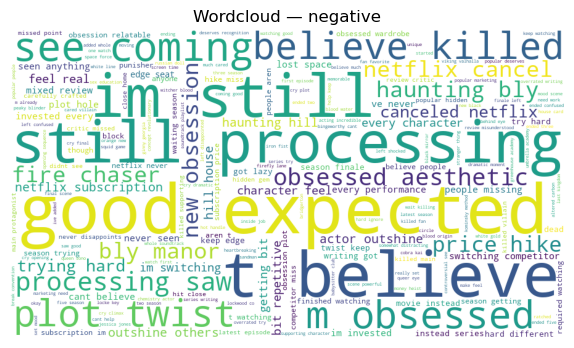

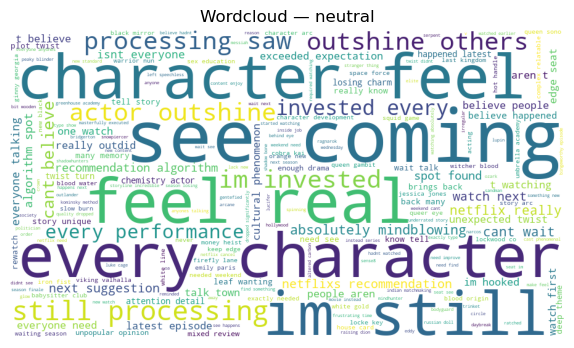

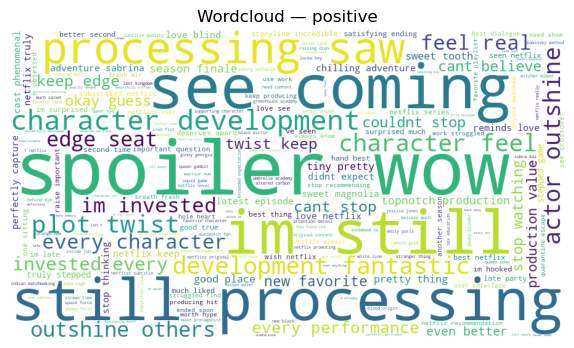

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for lab in sorted(df["vader_label"].unique()):
    text_blob = " ".join(df.loc[df["vader_label"]==lab, "clean"])
    wc = WordCloud(width=900,height=500,background_color="white").generate(text_blob)
    plt.figure(figsize=(8,4))
    plt.imshow(wc); plt.axis("off"); plt.title(f"Wordcloud — {lab}")
    plt.show()


In [ ]:
%pip install gensim


In [ ]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

tokens = [t.split() for t in df["clean"].dropna()]
dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(t) for t in tokens]

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=5, random_state=42)
for i in range(5):
    print(f"\nTopic {i}: {lda.print_topic(i, topn=10)}")


In [ ]:
import joblib, os
os.makedirs("models", exist_ok=True)
joblib.dump(vec, "models/tfidf.joblib")
joblib.dump(clf, "models/linearsvc.joblib")
